In [19]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/lustre/work/client/users/ejlaird/.conda/envs/quantum/lib/python3.9/site-packages/pkg_resources/__init__.py'>

In [ ]:
!pip install tensorflow-probability==0.15.0

In [20]:
import tensorflow as tf
import tensorflow_quantum as tfq

import gym, cirq, sympy
import numpy as np
from functools import reduce
from collections import deque, defaultdict
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
tf.get_logger().setLevel('ERROR')

In [3]:
def one_qubit_rotation(qubit, symbols):
    """
    Returns Cirq gates that apply a rotation of the bloch sphere about the X,
    Y and Z axis, specified by the values in `symbols`.
    """
    return [cirq.rx(symbols[0])(qubit),
            cirq.ry(symbols[1])(qubit),
            cirq.rz(symbols[2])(qubit)]

def entangling_layer(qubits):
    """
    Returns a layer of CZ entangling gates on `qubits` (arranged in a circular topology).
    """
    cz_ops = [cirq.CZ(q0, q1) for q0, q1 in zip(qubits, qubits[1:])]
    cz_ops += ([cirq.CZ(qubits[0], qubits[-1])] if len(qubits) != 2 else [])
    return cz_ops

In [4]:
def generate_circuit(qubits, n_layers):
    """Prepares a data re-uploading circuit on `qubits` with `n_layers` layers."""
    # Number of qubits
    n_qubits = len(qubits)

    # Sympy symbols for variational angles
    params = sympy.symbols(f'theta(0:{3*(n_layers+1)*n_qubits})')
    params = np.asarray(params).reshape((n_layers + 1, n_qubits, 3))

    # Sympy symbols for encoding angles
    inputs = sympy.symbols(f'x(0:{n_layers})'+f'_(0:{n_qubits})')
    inputs = np.asarray(inputs).reshape((n_layers, n_qubits))

    # Define circuit
    circuit = cirq.Circuit()
    for l in range(n_layers):
        # Variational layer
        circuit += cirq.Circuit(one_qubit_rotation(q, params[l, i]) for i, q in enumerate(qubits))
        circuit += entangling_layer(qubits)
        # Encoding layer
        circuit += cirq.Circuit(cirq.rx(inputs[l, i])(q) for i, q in enumerate(qubits))

    # Last varitional layer
    circuit += cirq.Circuit(one_qubit_rotation(q, params[n_layers, i]) for i,q in enumerate(qubits))

    return circuit, list(params.flat), list(inputs.flat)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

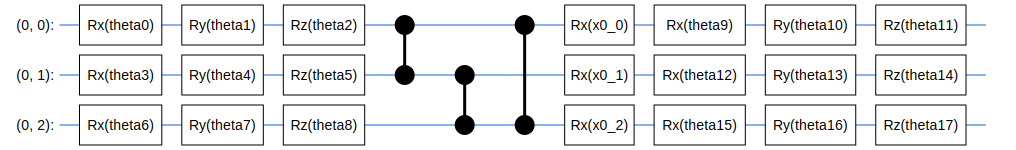

In [5]:
n_qubits, n_layers = 3, 1
qubits = cirq.GridQubit.rect(1, n_qubits)
circuit, _, _ = generate_circuit(qubits, n_layers)
SVGCircuit(circuit)

In [6]:
class ReUploadingPQC(tf.keras.layers.Layer):
    """
    Performs the transformation (s_1, ..., s_d) -> (theta_1, ..., theta_N, lmbd[1][1]s_1, ..., lmbd[1][M]s_1,
        ......., lmbd[d][1]s_d, ..., lmbd[d][M]s_d) for d=input_dim, N=theta_dim and M=n_layers.
    An activation function from tf.keras.activations, specified by `activation` ('linear' by default) is
        then applied to all lmbd[i][j]s_i.
    All angles are finally permuted to follow the alphabetical order of their symbol names, as processed
        by the ControlledPQC.
    """

    def __init__(self, qubits, n_layers, observables, activation="linear", name="re-uploading_PQC"):
        super(ReUploadingPQC, self).__init__(name=name)
        self.n_layers = n_layers
        self.n_qubits = len(qubits)

        circuit, theta_symbols, input_symbols = generate_circuit(qubits, n_layers)

        theta_init = tf.random_uniform_initializer(minval=0.0, maxval=np.pi)
        self.theta = tf.Variable(
            initial_value=theta_init(shape=(1, len(theta_symbols)), dtype="float32"),
            trainable=True, name="thetas"
        )

        lmbd_init = tf.ones(shape=(self.n_qubits * self.n_layers,))
        self.lmbd = tf.Variable(
            initial_value=lmbd_init, dtype="float32", trainable=True, name="lambdas"
        )

        self.logZ = tf.Variable(
            initial_value=0.0, dtype="float32", trainable=True, name="logZ"
        )

        # Define explicit symbol order.
        symbols = [str(symb) for symb in theta_symbols + input_symbols]
        self.indices = tf.constant([symbols.index(a) for a in sorted(symbols)])

        self.activation = activation
        self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])
        self.computation_layer = tfq.layers.ControlledPQC(circuit, observables)        

    def call(self, inputs):
        # inputs[0] = encoding data for the state.
        batch_dim = tf.gather(tf.shape(inputs[0]), 0)
        tiled_up_circuits = tf.repeat(self.empty_circuit, repeats=batch_dim)
        tiled_up_thetas = tf.tile(self.theta, multiples=[batch_dim, 1])
        tiled_up_inputs = tf.tile(inputs[0], multiples=[1, self.n_layers])
        scaled_inputs = tf.einsum("i,ji->ji", self.lmbd, tiled_up_inputs)
        squashed_inputs = tf.keras.layers.Activation(self.activation)(scaled_inputs)

        joined_vars = tf.concat([tiled_up_thetas, squashed_inputs], axis=1)
        joined_vars = tf.gather(joined_vars, self.indices, axis=1)

        return self.computation_layer([tiled_up_circuits, joined_vars])

In [8]:
n_qubits = 4 # Dimension of the state vectors in CartPole
n_layers = 5 # Number of layers in the PQC
n_actions = 2 # Number of actions in CartPole

qubits = cirq.GridQubit.rect(1, n_qubits)

In [9]:
ops = [cirq.Z(q) for q in qubits]
observables = [reduce((lambda x, y: x * y), ops)] # Z_0*Z_1*Z_2*Z_3

# PQC-GFlowNet

## Smiley

In [23]:
class ReUploadingPQC(tf.keras.layers.Layer):
    """
    Performs the transformation (s_1, ..., s_d) -> (theta_1, ..., theta_N, lmbd[1][1]s_1, ..., lmbd[1][M]s_1,
        ......., lmbd[d][1]s_d, ..., lmbd[d][M]s_d) for d=input_dim, N=theta_dim and M=n_layers.
    An activation function from tf.keras.activations, specified by `activation` ('linear' by default) is
        then applied to all lmbd[i][j]s_i.
    All angles are finally permuted to follow the alphabetical order of their symbol names, as processed
        by the ControlledPQC.
    """

    def __init__(self, qubits, n_layers, observables, activation="linear", name="re-uploading_PQC", noise=False):
        super(ReUploadingPQC, self).__init__(name=name)
        self.n_layers = n_layers
        self.n_qubits = len(qubits)

        circuit, theta_symbols, input_symbols = generate_circuit(qubits, n_layers)

        theta_init = tf.random_uniform_initializer(minval=0.0, maxval=np.pi)
        self.theta = tf.Variable(
            initial_value=theta_init(shape=(1, len(theta_symbols)), dtype="float32"),
            trainable=True, name="thetas"
        )

        lmbd_init = tf.ones(shape=(self.n_qubits * self.n_layers,))
        self.lmbd = tf.Variable(
            initial_value=lmbd_init, dtype="float32", trainable=True, name="lambdas"
        )

        self.logZ = tf.Variable(
            initial_value=1.0, dtype="float32", trainable=True, name="logZ"
        )

        # Define explicit symbol order.
        symbols = [str(symb) for symb in theta_symbols + input_symbols]
        self.indices = tf.constant([symbols.index(a) for a in sorted(symbols)])

        self.activation = activation
        self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])
        if not noise:
            self.computation_layer = tfq.layers.ControlledPQC(circuit, observables)
        else:
            self.computation_layer = tfq.layers.NoisyControlledPQC(circuit, observables)

    def call(self, inputs):
        # inputs[0] = encoding data for the state.
        batch_dim = tf.gather(tf.shape(inputs[0]), 0)
        tiled_up_circuits = tf.repeat(self.empty_circuit, repeats=batch_dim)
        tiled_up_thetas = tf.tile(self.theta, multiples=[batch_dim, 1])
        tiled_up_inputs = tf.tile(inputs[0], multiples=[1, self.n_layers])
        scaled_inputs = tf.einsum("i,ji->ji", self.lmbd, tiled_up_inputs)
        squashed_inputs = tf.keras.layers.Activation(self.activation)(scaled_inputs)

        joined_vars = tf.concat([tiled_up_thetas, squashed_inputs], axis=1)
        joined_vars = tf.gather(joined_vars, self.indices, axis=1)

        return self.computation_layer([tiled_up_circuits, joined_vars])

In [24]:
class Alternating(tf.keras.layers.Layer):
    def __init__(self, output_dim, init_val=-1.0):
        super(Alternating, self).__init__()
        self.w = tf.Variable(
            initial_value=tf.constant([[(init_val)**i for i in range(output_dim)]]), dtype="float32",
            trainable=True, name="obs-weights")

    def call(self, inputs):
        return tf.matmul(inputs, self.w)

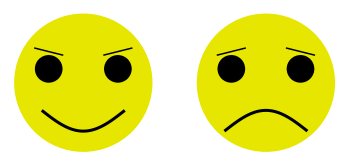

In [7]:
import matplotlib.pyplot as pp
import numpy as np
base_face = lambda: (pp.gca().add_patch(pp.Circle((0.5,0.5),0.5,fc=(.9,.9,0))),
                     pp.gca().add_patch(pp.Circle((0.25,0.6),0.1,fc=(0,0,0))),
                     pp.gca().add_patch(pp.Circle((0.75,0.6),0.1,fc=(0,0,0))))
patches = {
  'smile': lambda: pp.gca().add_patch(pp.Polygon(np.stack([np.linspace(0.2,0.8), 0.3-np.sin(np.linspace(0,3.14))*0.15]).T, closed=False, fill=False, lw=3)),
  'frown': lambda: pp.gca().add_patch(pp.Polygon(np.stack([np.linspace(0.2,0.8), 0.15+np.sin(np.linspace(0,3.14))*0.15]).T, closed=False, fill=False, lw=3)),
  'left_eb_down': lambda: pp.gca().add_line(pp.Line2D([0.15, 0.35], [0.75,0.7], color=(0,0,0))),
  'right_eb_down': lambda: pp.gca().add_line(pp.Line2D([0.65, 0.85], [0.7,0.75], color=(0,0,0))),
  'left_eb_up': lambda: pp.gca().add_line(pp.Line2D([0.15, 0.35], [0.7,0.75], color=(0,0,0))),
  'right_eb_up': lambda: pp.gca().add_line(pp.Line2D([0.65, 0.85], [0.75,0.7], color=(0,0,0))),
}
sorted_keys = sorted(patches.keys())

def draw_face(face):
  base_face()
  for i in face:
    patches[i]()
  pp.axis('scaled')
  pp.axis('off')

f, ax = pp.subplots(1,2)
pp.sca(ax[0])
draw_face(['smile', 'left_eb_down', 'right_eb_down'])
pp.sca(ax[1])
draw_face(['frown', 'left_eb_up', 'right_eb_up'])

#### Smiley Reward

In [25]:
def has_overlap(face):
  # Can't have two overlapping eyebrows!
  if 'left_eb_down' in face and 'left_eb_up' in face:
    return True
  if 'right_eb_down' in face and 'right_eb_up' in face:
    return True
  # Can't have two overlapping mouths!
  if 'smile' in face and 'frown' in face:
    return True
  return False

def face_reward(face):
  if has_overlap(face):
    return tf.constant(0.0)
  eyebrows = 'left_eb_down', 'left_eb_up', 'right_eb_down', 'right_eb_up'
  # Must have exactly two eyebrows
  if sum([i in face for i in eyebrows]) != 2:
    return tf.constant(0.0)
  # We want twice as many happy faces as sad faces so here we give a reward of 2 for smiles
  if 'smile' in face:
    return tf.constant(4.0)
  if 'frown' in face:
    return tf.constant(2.0)  # and a reward of 1 for frowns
  # If we reach this point, there's no mouth
  return tf.constant(0.0)

# reversed
# def face_reward(face):
#   if has_overlap(face):
#     return tf.constant(0.0)
#   eyebrows = 'left_eb_down', 'left_eb_up', 'right_eb_down', 'right_eb_up'
#   # Must have exactly two eyebrows
#   if sum([i in face for i in eyebrows]) != 2:
#     return tf.constant(0.0)
#   # We want twice as many happy faces as sad faces so here we give a reward of 2 for smiles
#   if 'smile' in face:
#     return tf.constant(2.0)
#   if 'frown' in face:
#     return tf.constant(4.0)  # and a reward of 1 for frowns
#   # If we reach this point, there's no mouth
#   return tf.constant(0.0)

unsorted_keys = ['smile', 'frown', 'left_eb_down', 'right_eb_down', 'left_eb_up', 'right_eb_up']

# We first define how the model will view a face, i.e. how to encode a face in
# a tensor
def face_to_tensor(face):
  return tf.convert_to_tensor([tf.constant([float(i in face) for i in unsorted_keys], dtype=tf.float32)])

In [26]:
class ActionMasking(tf.keras.layers.Layer):
    def __init__(self, state_size, mask_value=-100, pass_through=False):
        super(ActionMasking, self).__init__()
        self.state_size = state_size
        self.mask_value = mask_value
        self.pass_through = pass_through

    def call(self, logits, x):
        indices_f = tf.range(self.state_size)
        indices_b = tf.range(self.state_size, self.state_size * 2)
        
        if not self.pass_through:
            P_f = tf.gather(logits, indices_f, axis=1) * (1 - x) + x * self.mask_value
            P_b = tf.gather(logits, indices_b, axis=1) * x + (1 - x) * self.mask_value
        else:
            P_f = tf.gather(logits, indices_f, axis=1)
            P_b = tf.gather(logits, indices_b, axis=1)
            
        return P_f, P_b

In [27]:
n_qubits = 6 # Dimension of the state vectors in Smiley
n_layers = 5 # Number of layers in the PQC
n_actions = 6*2 # Number of actions in Smiley

qubits = cirq.GridQubit.rect(1, n_qubits)

ops = [cirq.Z(q) for q in qubits]
observables = [reduce((lambda x, y: x * y), ops)] # Z_0*Z_1*Z_2*Z_3

In [28]:
def generate_forward_flow(qubits, n_layers, n_actions, beta, observables):
    """Generates a Keras model for a data re-uploading PQC Gflownet."""

    input_tensor = tf.keras.Input(shape=(len(qubits), ), dtype=tf.dtypes.float32, name='input')
    re_uploading_pqc = ReUploadingPQC(qubits, n_layers, observables)([input_tensor])
    alternating = Alternating(n_actions)(re_uploading_pqc)
    lmbd1 = tf.keras.layers.Lambda(lambda x: x * beta)(alternating)
    action_masking = ActionMasking(n_qubits, mask_value=-100)(lmbd1, input_tensor)

    model = tf.keras.Model(inputs=[input_tensor], outputs=action_masking)

    return model

model = generate_forward_flow(qubits, n_layers, n_actions, 1.0, observables)

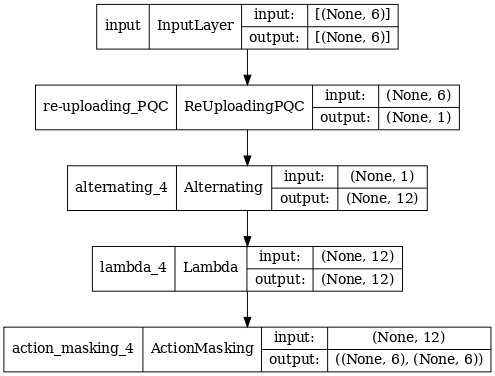

In [30]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

### PQC-Gflownet Training Loop

In [29]:
model = generate_forward_flow(qubits, n_layers, n_actions, 1.0, observables)

optimizer_in = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=False)
optimizer_var = tf.keras.optimizers.Adam(learning_rate=0.01, amsgrad=False)
optimizer_out = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=False)
optimizer_logz = tf.keras.optimizers.Adam(learning_rate=0.0001, amsgrad=False)

# Assign the model parameters to each optimizer
w_in, w_var, w_out, w_logz = 1, 0, 3, 2

In [58]:
from tqdm import tqdm
import tensorflow_probability as tfp
Categorical = tfp.distributions.Categorical

NUM_EPISODES = 50000
REWARD_SCALE = 1.0
update_freq = 10
minibatch_loss = 0.0
all_actions = []

sampled_faces = []
losses = []
grads_list = []
logZs = []

for episode in (pbar := tqdm(range(NUM_EPISODES))):
    state = []
    
    total_forward_flow = 0.0
    total_backward_flow = 0.0

    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)

        for t in range(3):

            # compute flows 
            p_f, p_b = model(face_to_tensor(state))

            cat = Categorical(logits=p_f[0])
            action = cat.sample().numpy()
            all_actions.append(action)
            # take action
            new_state = state + [unsorted_keys[action]]

            # accumulate forward flow
            total_forward_flow += cat.log_prob(action)

            if t == 2:
                reward = face_reward(new_state) * REWARD_SCALE

            # recompute flows for new state
            p_f, p_b = model(face_to_tensor(new_state))

            # accumulate backward flow
            total_backward_flow += Categorical(logits=p_b[0]).log_prob(action)

            # update state
            state = new_state

        # compute loss
        loss = tf.square(model.trainable_variables[w_logz] + total_forward_flow - tf.clip_by_value(tf.math.log(reward), -20, 10) - total_backward_flow)
        #loss = tf.square(np.log(12.0) + total_forward_flow - tf.clip_by_value(tf.math.log(reward), -20, 10) - total_backward_flow)
        minibatch_loss += loss

    sampled_faces.append(state)
    if episode % update_freq == 0:
        # gradient update
        grads = tape.gradient(minibatch_loss, model.trainable_variables)
        for optimizer, w in zip([optimizer_in, optimizer_var, optimizer_out, optimizer_logz], [w_in, w_var, w_out, w_logz]):
            optimizer.apply_gradients([(grads[w], model.trainable_variables[w])])
        
        grads_list.append(grads)
        losses.append(minibatch_loss.numpy())
        logZs.append(model.trainable_variables[w_logz].numpy())
        minibatch_loss = 0.0
            



100%|██████████| 50000/50000 [44:02<00:00, 18.92it/s]  


In [63]:
# save trained weights
model.save_weights('qgflownet-frown_weights.h5')

In [49]:
np.log(2), np.log(1)

(0.6931471805599453, 0.0)

In [32]:
tf.square(model.trainable_variables[w_logz] + total_forward_flow - tf.clip_by_value(tf.math.log(reward), -20, 10) - total_backward_flow)

<tf.Tensor: shape=(), dtype=float32, numpy=278.2132>

In [26]:
t_f, t_b = model(face_to_tensor([]))
t_f[0]

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([ 0.43796086, -0.5033907 ,  0.49403414, -0.46507058,  0.52146244,
       -0.48752367], dtype=float32)>

In [29]:
total_forward_flow,total_backward_flow,tf.clip_by_value(tf.math.log(reward), -100, 10)

(<tf.Tensor: shape=(), dtype=float32, numpy=-4.041232>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.62426>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-100.0>)

In [14]:
from collections import Counter
Counter(all_actions)

Counter({5: 6259, 0: 6009, 2: 5785, 3: 4184, 4: 4001, 1: 3762})

<BarContainer object of 6 artists>

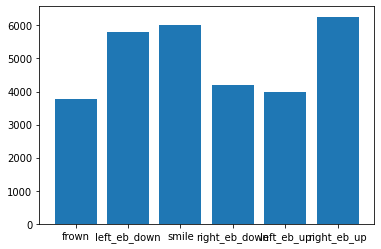

In [19]:
# make histogram of action counts by type

stratified_actions = Counter(all_actions)
pp.bar([unsorted_keys[i] for i in stratified_actions.keys()], stratified_actions.values())

In [36]:
sorted_keys

['frown',
 'left_eb_down',
 'left_eb_up',
 'right_eb_down',
 'right_eb_up',
 'smile']

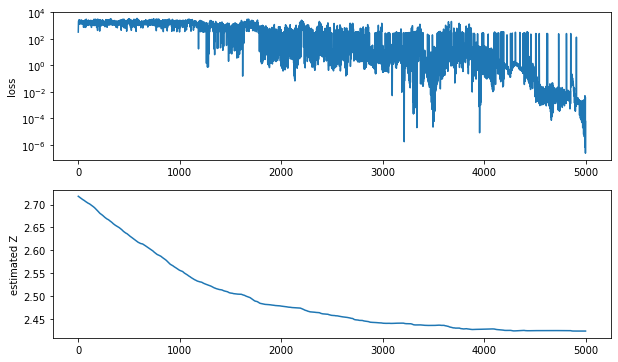

In [59]:
import numpy as np

f, ax = pp.subplots(2, 1, figsize=(10,6))
pp.sca(ax[0])
pp.plot(losses)
pp.yscale('log')
pp.ylabel('loss')
pp.sca(ax[1])
pp.plot(np.exp(logZs))
pp.ylabel('estimated Z');

Ratio of faces with a smile: 0.0
Ratio of valid faces: 1.0


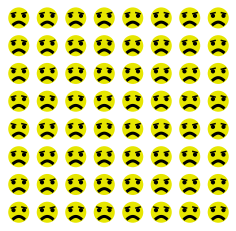

In [60]:
f, ax = pp.subplots(8,8,figsize=(4,4))
print('Ratio of faces with a smile:', sum(['smile' in i for i in sampled_faces[-128:]]) / 128)
print('Ratio of valid faces:', sum([face_reward(i).numpy() > 0 for i in sampled_faces[-128:]]) / 128)
for i, face in enumerate(sampled_faces[-64:]):
  pp.sca(ax[i//8,i%8])
  draw_face(face)

Ratio of faces with a smile: 0.484375
Ratio of valid faces: 0.4375


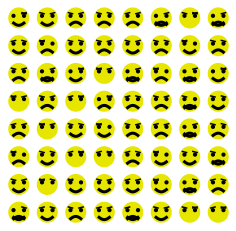

In [55]:
f, ax = pp.subplots(8,8,figsize=(4,4))
print('Ratio of faces with a smile:', sum(['smile' in i for i in sampled_faces[:128]]) / 128)
print('Ratio of valid faces:', sum([face_reward(i).numpy() > 0 for i in sampled_faces[:128]]) / 128)
for i, face in enumerate(sampled_faces[:64]):
  pp.sca(ax[i//8,i%8])
  draw_face(face)

In [61]:
def sample(model, N, keys=None):
    if keys is None:
        keys = ['smile', 'frown', 'left_eb_down', 'right_eb_down', 'left_eb_up', 'right_eb_up']
    sampled_faces = []
    for _ in range(N):
        state = []
        for _ in range(3):
            p_f, _ = model(face_to_tensor(state))
            action = Categorical(logits=p_f[0]).sample().numpy()
            new_state = state + [keys[action]]
            state = new_state
        sampled_faces.append(state)
    return sampled_faces

In [62]:
samples = sample(model, 100)
print('Ratio of faces with a smile:', sum(['smile' in i for i in samples]) / 100)
print('Ratio of valid faces:', sum([face_reward(i).numpy() > 0 for i in samples]) / 100)


Ratio of faces with a smile: 0.0
Ratio of valid faces: 1.0
